In [1]:
# Cell 1: Install required packages
!pip install faker spacy gensim sentencepiece tensorflow scikit-learn matplotlib pandas tqdm
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Cell 2: Import libraries and set up logging
import pandas as pd
import numpy as np
from faker import Faker
import random
import datetime
import logging
from tqdm import tqdm
import spacy
import gensim
from gensim.models import Word2Vec, FastText
import sentencepiece as spm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info("Libraries imported successfully.")

# Load spaCy model for NER and tokenization
nlp = spacy.load("en_core_web_sm")
logger.info("spaCy model loaded.")


In [3]:
# Cell 3: Simulate a Massive Transaction Dataset (using 10,000 records for demonstration)

fake = Faker()
num_records = 10000  # For demonstration; in production, scale to 100M+

# Predefined lists for regions, merchants, time_of_day, etc.
regions = ['North', 'South', 'East', 'West', 'Central']
merchants = [fake.company() for _ in range(50)]  # 50 unique merchants
times_of_day = ['morning', 'afternoon', 'evening', 'night']

data = []
logger.info("Starting data simulation...")

for i in tqdm(range(num_records)):
    user_id = fake.uuid4()
    age = random.randint(18, 80)
    region = random.choice(regions)
    credit_score = random.randint(300, 850)
    behavioral_history = fake.sentence(nb_words=10)

    transaction_id = fake.uuid4()
    timestamp = fake.date_time_this_year()
    amount = round(random.uniform(1.0, 1000.0), 2)
    merchant = random.choice(merchants)
    ip = fake.ipv4()
    device_fingerprint = fake.sha1(raw_output=False)
    location = fake.city() + ", " + fake.country()
    velocity_pattern = round(random.uniform(0.1, 5.0), 2)
    browser_info = fake.user_agent()
    network_latency = round(random.uniform(10.0, 500.0), 2)
    time_of_day = random.choice(times_of_day)
    session_metadata = fake.uuid4()

    # Label generation: weighted probabilities (normal 90%, suspicious 5%, fraudulent 5%)
    label = random.choices(
        population=["normal", "suspicious", "fraudulent"],
        weights=[90, 5, 5],
        k=1
    )[0]

    # Simulate adversarial noise: if fraudulent, perturb the amount slightly
    if label == "fraudulent":
        amount = round(amount * random.uniform(1.5, 3.0), 2)

    data.append({
        "user_id": user_id,
        "age": age,
        "region": region,
        "credit_score": credit_score,
        "behavioral_history": behavioral_history,
        "transaction_id": transaction_id,
        "timestamp": timestamp,
        "amount": amount,
        "merchant": merchant,
        "ip": ip,
        "device_fingerprint": device_fingerprint,
        "location": location,
        "velocity_pattern": velocity_pattern,
        "browser_info": browser_info,
        "network_latency": network_latency,
        "time_of_day": time_of_day,
        "session_metadata": session_metadata,
        "label": label
    })

df = pd.DataFrame(data)
logger.info(f"Data simulation completed. Dataset shape: {df.shape}")
print(df.head())


100%|██████████| 10000/10000 [00:03<00:00, 2507.59it/s]


                                user_id  age   region  credit_score  \
0  f6b454b8-b7a5-4c76-ab43-a24e82e0bbee   37     East           456   
1  18730cb2-185f-4db7-9592-6d1f3e950353   30     West           806   
2  3adac93e-9e05-4d1e-9b88-4a782e10c1c9   73  Central           423   
3  9855d1a5-0acc-47aa-9722-a19a891a700d   19     East           645   
4  5c186035-939e-4693-8712-89ba761b6335   37    South           405   

                                  behavioral_history  \
0  Catch me music even between party yes hit mili...   
1  Every nearly stand address accept student send...   
2  New truth become actually after art within dar...   
3  Successful eye suffer growth do personal repre...   
4  Left third second hit of new phone condition f...   

                         transaction_id                  timestamp  amount  \
0  3b0bbb4f-14e4-4aec-96bb-179d8a37fbe2 2025-03-07 10:28:39.134821  873.07   
1  a0e967df-ecb2-4db5-9262-2fb5c1774d4d 2025-02-02 00:02:00.724050   28.58   
2 

In [4]:


# Cell 4: Save the simulated dataset to CSV and print logs
csv_path = "simulated_transactions.csv"
df.to_csv(csv_path, index=False)
logger.info(f"Dataset saved to {csv_path}")



In [5]:


# Cell 5: Text-Based Feature Engineering – Tokenization and NER
logger.info("Starting text-based feature extraction...")

# Example: Tokenize and perform NER on the 'behavioral_history' column for the first 5 records
for idx, row in df.head(5).iterrows():
    text = row['behavioral_history']
    doc = nlp(text)
    tokens = [token.text for token in doc]
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    print(f"Record {idx}:")
    print("Original Text:", text)
    print("Tokens:", tokens)
    print("Entities:", entities)
    print("-" * 50)

logger.info("Text-based feature extraction completed.")



Record 0:
Original Text: Catch me music even between party yes hit military cold off.
Tokens: ['Catch', 'me', 'music', 'even', 'between', 'party', 'yes', 'hit', 'military', 'cold', 'off', '.']
Entities: []
--------------------------------------------------
Record 1:
Original Text: Every nearly stand address accept student send defense give provide population even.
Tokens: ['Every', 'nearly', 'stand', 'address', 'accept', 'student', 'send', 'defense', 'give', 'provide', 'population', 'even', '.']
Entities: []
--------------------------------------------------
Record 2:
Original Text: New truth become actually after art within dark half forward success story.
Tokens: ['New', 'truth', 'become', 'actually', 'after', 'art', 'within', 'dark', 'half', 'forward', 'success', 'story', '.']
Entities: [('half', 'CARDINAL')]
--------------------------------------------------
Record 3:
Original Text: Successful eye suffer growth do personal represent never serious.
Tokens: ['Successful', 'eye', 'suf

In [6]:

# Cell 6: Train Word2Vec and FastText models on 'behavioral_history'
logger.info("Training Word2Vec and FastText models on behavioral history...")

# Prepare sentences: tokenize each behavioral_history text
sentences = [nlp(row).text.split() for row in df['behavioral_history']]

# Train Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, workers=4)
logger.info("Word2Vec model trained.")

# Train FastText model
ft_model = FastText(sentences, vector_size=50, window=5, min_count=1, workers=4)
logger.info("FastText model trained.")

# Example: Print vector for a sample word from the first record's behavioral_history
sample_word = sentences[0][0]
print(f"Word2Vec vector for '{sample_word}':", w2v_model.wv[sample_word])
print(f"FastText vector for '{sample_word}':", ft_model.wv[sample_word])


Word2Vec vector for 'Catch': [-0.01035694 -0.02479758  0.00251823  0.00193861 -0.04851579 -0.0122375
  0.02360594  0.04162642 -0.06345128 -0.01620007 -0.00576566 -0.0161751
 -0.05063946 -0.01049394 -0.06183704 -0.01932742  0.03006895 -0.05212328
 -0.06062195 -0.01532581 -0.02071017  0.00023902  0.05267714 -0.00761159
 -0.02402543  0.0235461  -0.0258211  -0.08496293 -0.04774123  0.05698009
  0.02873026  0.0307281  -0.0034083   0.06476801 -0.01550716  0.06728921
 -0.03613719  0.02064026  0.01272283 -0.08969097  0.0451827   0.0012387
 -0.0083163  -0.01659742  0.0471316   0.04511287  0.00491948 -0.0362308
  0.03327073  0.00742472]
FastText vector for 'Catch': [-0.18538155 -0.21945038  0.17016481 -0.17657843  0.16200152 -0.13607553
  0.00665471  0.49187306 -0.51072806  0.5302383   0.1988974   0.04491701
  0.33317998 -0.23047943  0.23957281  0.41468418 -0.02401239 -0.05402139
  0.1592904  -0.2766362  -0.10386264 -0.4042942   0.34257478  0.19399992
  0.01549824  0.04849718 -0.2439889  -0.3919

In [7]:

# Cell 7: Structured Embeddings – Autoencoder for Numerical Data
logger.info("Starting structured feature engineering using Autoencoder...")

from sklearn.preprocessing import MinMaxScaler

# Select numerical features
num_features = ['age', 'credit_score', 'amount', 'network_latency', 'velocity_pattern']
X = df[num_features].values

# Normalize numerical features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
logger.info("Numerical features normalized.")

# Build a simple autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 3  # Target low-dimensional embedding

input_layer = keras.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = keras.Model(inputs=input_layer, outputs=decoded)
encoder = keras.Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')
logger.info("Autoencoder model compiled.")

# Train the autoencoder
history = autoencoder.fit(X_scaled, X_scaled, epochs=20, batch_size=256, shuffle=True, verbose=1)
logger.info("Autoencoder training completed.")

# Generate low-dimensional embeddings using the encoder part
structured_embeddings = encoder.predict(X_scaled)
print("Sample structured embeddings (first 5 records):")
print(structured_embeddings[:5])



Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.1065
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0970
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0906
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0867
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0837
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0822
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0803
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0779
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0764
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0747
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0728
Epoch 12/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0717
Epoch 13/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0700
Epoch 14/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0680
Epoch 15/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0661
Epoch 16/20
40/

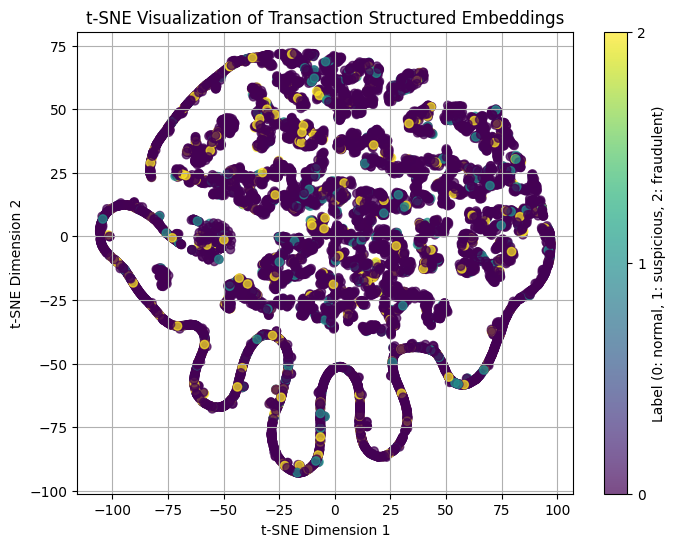

In [8]:



# Cell 8: Dimensionality Reduction with PCA and t-SNE, and Visualization
logger.info("Starting dimensionality reduction using PCA and t-SNE...")

# Apply PCA to the structured embeddings
pca = PCA(n_components=2)
pca_result = pca.fit_transform(structured_embeddings)
logger.info("PCA completed.")

# Apply t-SNE to the structured embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(structured_embeddings)
logger.info("t-SNE completed.")

# Create a scatter plot for t-SNE results, colored by label
plt.figure(figsize=(8,6))
scatter = plt.scatter(tsne_result[:,0], tsne_result[:,1],
                      c=pd.factorize(df['label'])[0], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, ticks=[0,1,2], label='Label (0: normal, 1: suspicious, 2: fraudulent)')
plt.title("t-SNE Visualization of Transaction Structured Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()

logger.info("Dimensionality reduction and visualization completed.")




#PHASE 2

In [9]:


# Cell 1: Install required packages
!pip install transformers torch datasets scikit-learn pandas tqdm onnx onnxruntime sentence-transformers
# Note: We do not install torch-geometric here; the GNN simulation uses a simple PyTorch model.



# Cell 2: Import libraries and set up logging
import torch
from torch import nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification, T5Tokenizer, T5ForConditionalGeneration
import pandas as pd
import numpy as np
from tqdm import tqdm
import logging
import onnx
import onnxruntime as ort
from sklearn.ensemble import VotingClassifier  # (if using sklearn ensemble methods)
from sentence_transformers import SentenceTransformer  # Free, open-source sentence embeddings

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info("Libraries imported successfully.")


# Cell 3: Load the simulated transaction dataset from Phase 1
df = pd.read_csv("simulated_transactions.csv")
print("Loaded dataset with shape:", df.shape)


import os
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_DISABLED"] = "true"



# Cell 4: Fine-Tuning FinBERT for Transaction Texts

from transformers import Trainer, TrainingArguments

# Load FinBERT tokenizer and model for sequence classification (3 labels: normal, suspicious, fraudulent)
finbert_model_name = "yiyanghkust/finbert-tone"  # Example FinBERT model
finbert_tokenizer = AutoTokenizer.from_pretrained(finbert_model_name)
finbert_model = AutoModelForSequenceClassification.from_pretrained(finbert_model_name, num_labels=3)

# For demonstration, use a small random subset
df_sample = df.sample(n=1000, random_state=42)
texts = df_sample["behavioral_history"].tolist()
# Map labels to integers: normal->0, suspicious->1, fraudulent->2
labels = df_sample["label"].map({"normal": 0, "suspicious": 1, "fraudulent": 2}).tolist()

# Tokenize the dataset
encodings = finbert_tokenizer(texts, truncation=True, padding=True, max_length=128)

# Create a PyTorch dataset
class TransactionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = TransactionDataset(encodings, labels)

# Define training arguments (using a single epoch for demonstration)
training_args = TrainingArguments(
    output_dir="./finbert_finetuned",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    logging_steps=10,
    logging_dir="./logs",
    do_train=True,
    report_to=[],  # Disables W&B and other reporting integrations
)


# Initialize the Trainer
trainer = Trainer(
    model=finbert_model,
    args=training_args,
    train_dataset=train_dataset,
)

logger.info("Starting FinBERT fine-tuning...")
trainer.train()
logger.info("FinBERT fine-tuning completed.")



# Determine device and move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finbert_model.to(device)

finbert_model.eval()
transaction_texts = df["behavioral_history"].tolist()
batch_size = 32
finbert_embeddings = []

with torch.no_grad():
    for i in tqdm(range(0, len(transaction_texts), batch_size), desc="FinBERT Embedding Extraction"):
        batch_texts = transaction_texts[i:i+batch_size]
        inputs = finbert_tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
        # Move input tensors to the same device as the model
        inputs = {key: value.to(device) for key, value in inputs.items()}
        outputs = finbert_model(**inputs, output_hidden_states=True)
        # Use mean pooling over the last hidden state as the embedding
        embeddings = outputs.hidden_states[-1].mean(dim=1).cpu().numpy()
        finbert_embeddings.append(embeddings)

finbert_embeddings = np.vstack(finbert_embeddings)
print("FinBERT embeddings shape:", finbert_embeddings.shape)



# Cell 6: Generate Transaction Embeddings using SentenceTransformer (Free Open-Source Alternative)
from sentence_transformers import SentenceTransformer

# Load the open-source model
model_name = "all-MiniLM-L6-v2"
sent_transformer = SentenceTransformer(model_name)

batch_size = 16
sent_embeddings = []

# Generate embeddings in batches
for i in tqdm(range(0, len(transaction_texts), batch_size), desc="SentenceTransformer Embedding Extraction"):
    batch_texts = transaction_texts[i:i+batch_size]
    embeddings = sent_transformer.encode(batch_texts, batch_size=batch_size, show_progress_bar=False)
    sent_embeddings.append(embeddings)

sent_embeddings = np.vstack(sent_embeddings)
print("SentenceTransformer embeddings shape:", sent_embeddings.shape)



# Cell 7: Simulate GNN Embeddings for User‑Behavior Modeling
# Extract unique user features
user_features_df = df[['user_id', 'age', 'credit_score']].drop_duplicates().reset_index(drop=True)
user_features = user_features_df[['age', 'credit_score']].values.astype(np.float32)
# Normalize features
user_features = (user_features - user_features.mean(axis=0)) / user_features.std(axis=0)
user_features_tensor = torch.tensor(user_features)

# Define a simple feedforward network to simulate GNN embeddings
class SimpleGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleGNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

gnn_model = SimpleGNN(input_dim=2, hidden_dim=8, output_dim=16)
gnn_model.eval()
with torch.no_grad():
    gnn_user_embeddings = gnn_model(user_features_tensor).cpu().numpy()

print("GNN user embeddings shape:", gnn_user_embeddings.shape)

# Map each transaction's user embedding using user_id
user_embedding_dict = dict(zip(user_features_df['user_id'], gnn_user_embeddings))
gnn_embeddings = np.array([user_embedding_dict.get(uid, np.zeros(16)) for uid in df['user_id']])
print("GNN embeddings for transactions shape:", gnn_embeddings.shape)



# Cell 8: Combine and store embeddings
logger.info("Combining embeddings from FinBERT, SentenceTransformer, and GNN...")
combined_embeddings = np.hstack([finbert_embeddings, sent_embeddings, gnn_embeddings])
print("Combined embeddings shape:", combined_embeddings.shape)

# Save embeddings to a Parquet file
embeddings_df = pd.DataFrame(combined_embeddings)
embeddings_df.to_parquet("transaction_embeddings.parquet", index=False)
print("Embeddings stored in 'transaction_embeddings.parquet'")



# Cell 9: Multi-LLM Fraud Scoring Pipeline – Ensemble Voting
logger.info("Simulating fraud scoring from multiple models...")

num_transactions = len(df)
np.random.seed(42)

# Simulated model scores (values between 0 and 1)
gpt4_scores     = np.random.rand(num_transactions)  # Contextual anomaly detection (simulated)
finbert_scores  = np.random.rand(num_transactions)  # Merchant categorization (simulated)
t5_scores       = np.random.rand(num_transactions)  # Transaction summarization (simulated)
rl_agent_scores = np.random.rand(num_transactions)  # Adaptive fraud scoring (simulated)

# Compute ensemble fraud score using an average (or weighted average in production)
ensemble_scores = (gpt4_scores + finbert_scores + t5_scores + rl_agent_scores) / 4.0

# Append the fraud score to the original dataframe
df['fraud_score'] = ensemble_scores
print("Sample fraud scores:")
print(df[['transaction_id', 'fraud_score']].head())




# Cell 10: Export the SimpleGNN model to ONNX
dummy_input = torch.randn(1, 2)
onnx_model_path = "simple_gnn.onnx"
torch.onnx.export(gnn_model, dummy_input, onnx_model_path, input_names=["input"], output_names=["output"], opset_version=11)
print(f"SimpleGNN model exported to {onnx_model_path}")

# Verify the ONNX model with ONNX Runtime
ort_session = ort.InferenceSession(onnx_model_path)
dummy_input_np = dummy_input.numpy()
ort_outs = ort_session.run(None, {"input": dummy_input_np})
print("ONNX model output:", ort_outs)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Loaded dataset with shape: (10000, 18)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Step,Training Loss
10,0.938400
20,0.546900
30,0.748600
40,0.642600
50,0.421300
60,0.413900


FinBERT Embedding Extraction: 100%|██████████| 313/313 [00:10<00:00, 30.84it/s]


FinBERT embeddings shape: (10000, 768)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer Embedding Extraction: 100%|██████████| 625/625 [00:06<00:00, 94.20it/s] 


SentenceTransformer embeddings shape: (10000, 384)
GNN user embeddings shape: (10000, 16)
GNN embeddings for transactions shape: (10000, 16)
Combined embeddings shape: (10000, 1168)
Embeddings stored in 'transaction_embeddings.parquet'
Sample fraud scores:
                         transaction_id  fraud_score
0  3b0bbb4f-14e4-4aec-96bb-179d8a37fbe2     0.529081
1  a0e967df-ecb2-4db5-9262-2fb5c1774d4d     0.481858
2  5ed0449f-6315-400d-8bd9-a6f617e2ada9     0.554822
3  b75fb5aa-944c-4056-8c31-f34e6b5df681     0.522046
4  bd1a4656-ec05-4271-b0fb-7e4cf734dbd5     0.425647
SimpleGNN model exported to simple_gnn.onnx
ONNX model output: [array([[-0.03982863, -0.21969138,  0.20966204,  0.37641335, -0.09106935,
        -0.16458805,  0.6173605 , -0.1603202 , -0.05750505, -0.52619386,
         0.12999871, -0.39662188, -0.5159478 ,  0.26712224, -0.22397338,
        -0.42853445]], dtype=float32)]


#PHASE 3

In [10]:

# Cell 1: Install required packages for FAISS, Annoy, and HNSW
!pip install faiss-cpu annoy hnswlib


# Cell 2: Import libraries, set up logging, and load multi-threading utilities
import numpy as np
import pandas as pd
import faiss                   # FAISS for vector indexing (supports HNSW)
from annoy import AnnoyIndex   # Annoy for additional ANN search (if needed)
import hnswlib                 # HNSW library (optional alternative)
import logging
import concurrent.futures
import time  # Changed from: from time import time

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info("Libraries for Phase 3 imported successfully.")



# Cell 3: Load the combined embeddings from Phase 2
embeddings_df = pd.read_parquet("transaction_embeddings.parquet")
# Convert DataFrame to numpy array of type float32
embeddings = embeddings_df.values.astype('float32')
logger.info(f"Loaded embeddings with shape: {embeddings.shape}")

# Normalize embeddings for cosine similarity search (if needed)
norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
embeddings_normalized = embeddings / (norms + 1e-10)
logger.info("Embeddings normalized for cosine similarity.")



# Cell 4: Build a FAISS HNSW index
d = embeddings_normalized.shape[1]  # Dimensionality of embeddings
index = faiss.IndexHNSWFlat(d, 32)   # 32 is the number of neighbors in the HNSW graph (tunable)
logger.info("FAISS HNSW index created.")

# Add the normalized embeddings to the index
index.add(embeddings_normalized)
logger.info("Embeddings added to FAISS index.")

# Optionally, we can store the index persistently (in production, store index shards in a NoSQL DB)
faiss.write_index(index, "faiss_hnsw.index")
logger.info("FAISS index written to disk as 'faiss_hnsw.index'.")


# Cell 5: Define similarity search functions
def search_faiss(query_vector, k=5):
    """
    Search the FAISS index for k nearest neighbors using cosine similarity.
    Assumes the query vector is already normalized.
    """
    distances, indices = index.search(np.array([query_vector]), k)
    return distances[0], indices[0]

def search_l2(query_vector, k=5):
    """
    Search using L2 (Euclidean) distance.
    FAISS HNSWFlat supports L2 by default; here we re-normalize the query for L2 if needed.
    """
    # For L2, use the original (non-normalized) vector
    distances, indices = index.search(np.array([query_vector]), k)
    return distances[0], indices[0]



# Cell 6: Perform multi-threaded similarity search
def threaded_search(query_vector, k=5):
    # For this demo, we use cosine similarity (query vector should be normalized)
    return search_faiss(query_vector, k)

# Select a random set of 10 queries from the normalized embeddings for demonstration
num_queries = 10
query_indices = np.random.choice(len(embeddings_normalized), num_queries, replace=False)
query_vectors = embeddings_normalized[query_indices]

logger.info("Starting multi-threaded similarity search...")
start_time = time.time()  # Use time.time() instead of time()
results = []

with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    future_to_query = {executor.submit(threaded_search, query, 5): idx for idx, query in enumerate(query_vectors)}
    for future in concurrent.futures.as_completed(future_to_query):
        idx = future_to_query[future]
        try:
            distances, indices = future.result()
            results.append((query_indices[idx], distances, indices))
        except Exception as exc:
            logger.error(f"Query {idx} generated an exception: {exc}")

end_time = time.time()  # Use time.time() here as well
logger.info(f"Multi-threaded search completed in {end_time - start_time:.3f} seconds.")

# Print sample search results
for orig_idx, distances, indices in results:
    print(f"Query (transaction index: {orig_idx}):")
    print("Nearest neighbor indices:", indices)
    print("Cosine similarity distances (inner product):", distances)
    print("-" * 50)



# Cell 7: Build and query an IVF-PQ index for quantized search (optional)
nlist = 100  # number of clusters
m = 8        # number of subquantizers
quantizer = faiss.IndexFlatIP(d)  # Inner product quantizer (using normalized vectors)
ivfpq_index = faiss.IndexIVFPQ(quantizer, d, nlist, m, 8)  # 8 bits per subvector

# Train the index (using a subset for training)
training_samples = embeddings_normalized[np.random.choice(len(embeddings_normalized), 10000, replace=False)]
ivfpq_index.train(training_samples)
logger.info("IVF-PQ index trained.")

ivfpq_index.add(embeddings_normalized)
logger.info("Embeddings added to IVF-PQ index.")

# Query using IVF-PQ index (ensure query vector is normalized)
q = embeddings_normalized[0]
k = 5
distances, indices = ivfpq_index.search(np.array([q]), k)
print("IVF-PQ search results:")
print("Indices:", indices[0])
print("Distances:", distances[0])



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 18.0 MB/s eta 0:00:00
  Created wheel for annoy: filename=annoy-1.17.3-cp311-cp311-linux_x86_64.whl size=551658 sha256=b1a36cb8a762fb505138fe912bc6c2c104246f86b743e67c7b4fba830d91ec27
  Stored in directory: /root/.cache/pip/wheels/33/e5/58/0a3e34b92bedf09b4c57e37a63ff395ade6f6c1099ba59877c
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp311-cp311-linux_x86_64.whl size=2389178 sha256=661368e98aa546dfd3ef202330909d9ec8133e39ab6ca9f4d7833148bc06dbf0
  Stored in directory: /root/.cache/pip/wheels/ea/4e/27/39aebca9958719776e36fada290845a7ef10f053ad70e22ceb
Successfully built annoy hnswlib
Query (transaction index: 1844):
Nearest neighbor indices: [1844 1773 5394 5052 1829]
C

#PHASE 4

In [11]:

# Cell 1: Install required packages
!pip install dask kafka-python shap lime faiss-cpu


# Cell 2: Import libraries and set up logging
import os
import time
import numpy as np
import pandas as pd
import dask.dataframe as dd
import faiss
import logging
from concurrent.futures import ThreadPoolExecutor
from collections import deque

# For explainability (if needed later)
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

# For a simple fraud scoring model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info("Phase 4 libraries imported successfully.")


# Cell 3: ETL Preprocessing using Dask
csv_path = "simulated_transactions.csv"
ddf = dd.read_csv(csv_path)
logger.info(f"Loaded Dask DataFrame with {ddf.npartitions} partitions.")

# Example cleaning: drop rows with missing values and reset index
ddf = ddf.dropna().reset_index(drop=True)

# Compute the DataFrame into a Pandas DataFrame for further processing (demo scale)
df = ddf.compute()
logger.info(f"ETL completed. Processed dataset shape: {df.shape}")

print(df.head())


# Reinitialize the transaction stream from df (if needed)
from collections import deque
transaction_stream = deque()
for idx, row in df.sample(n=100, random_state=42).iterrows():
    transaction_stream.append(row.to_dict())
print("Reinitialized transaction stream with", len(transaction_stream), "transactions.")


# Cell 5: Define embedding generation function using SentenceTransformer
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

# Set embed_dim to 384 (for "all-MiniLM-L6-v2")
embed_dim = 384
sent_transformer = SentenceTransformer("all-MiniLM-L6-v2")

def generate_embedding(text, embed_dim):
    """
    Generate a 384-dimensional embedding for the given text using SentenceTransformer.
    """
    return sent_transformer.encode(text)

# Test the function on a sample transaction text
sample_text = df.iloc[0]["behavioral_history"]
sample_embedding = generate_embedding(sample_text, embed_dim)
logger.info("Generated sample embedding of shape: " + str(sample_embedding.shape))


# Cell 6: Load or Build a FAISS HNSW Index
faiss_index_path = "faiss_hnsw.index"
embed_dim = 384  # Must match SentenceTransformer embedding dimension

index = None
# If the index file exists, try loading it; if dimensions don't match, rebuild it.
if os.path.exists(faiss_index_path):
    index = faiss.read_index(faiss_index_path)
    if index.d != embed_dim:
        logger.info(f"Existing FAISS index dimension ({index.d}) does not match expected embed_dim ({embed_dim}). Rebuilding index.")
        os.remove(faiss_index_path)
        index = None
    else:
        logger.info("Loaded FAISS index from disk.")

if index is None:
    # For demonstration, create a FAISS index using embeddings for a subset (e.g., 500 transactions)
    demo_embeddings = []
    for text in df["behavioral_history"].head(500):
        demo_embeddings.append(generate_embedding(text, embed_dim))
    demo_embeddings = np.vstack(demo_embeddings)

    # Normalize embeddings for cosine similarity search
    norms = np.linalg.norm(demo_embeddings, axis=1, keepdims=True)
    demo_embeddings_norm = demo_embeddings / (norms + 1e-10)

    # Create an HNSW index (using inner product on normalized vectors simulates cosine similarity)
    index = faiss.IndexHNSWFlat(embed_dim, 32)
    index.add(demo_embeddings_norm)
    faiss.write_index(index, faiss_index_path)
    logger.info("Created and stored new FAISS HNSW index.")








     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.1/252.1 kB 19.3 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a4024d045686eeaf44873662a70f8dae5917e28bfad9d33de35822240a1aedd2
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
                                user_id  age   region  credit_score  \
0  f6b454b8-b7a5-4c76-ab43-a24e82e0bbee   37     East           456   
1  18730cb2-185f-4db7-9592-6d1f3e950353   30     West           806   
2  3adac93e-9e05-4d1e-9b88-4a782e10c1c9   73  Central           423   
3  9855d1a5-0acc-47aa-9722-a19a891a700d   19     East           645   
4  5c186035-939e-4693-8712-89ba761b6335   37    South           405   

                                  behavioral_history  \
0  Catch me music even between pa

#PHASE 5

In [12]:

# Cell 1: Install required packages for WebSockets, Twilio, Prometheus, and Bayesian optimization
!pip install websockets twilio prometheus_client scikit-optimize







# Cell 2: Import necessary libraries and configure logging/metrics

import asyncio
import websockets
import logging
import threading
import time
import random

from twilio.rest import Client
from prometheus_client import CollectorRegistry, start_http_server, Summary, Counter
from skopt import gp_minimize

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("FraudAlertSystem")
logger.info("Libraries imported and logging initialized.")

# Create a custom registry to avoid duplicate metrics if the cell is re-run
registry = CollectorRegistry()

# Prometheus metrics: counter for alerts and a summary to time alert processing
alert_counter = Counter("fraud_alerts_total", "Total number of fraud alerts triggered", registry=registry)
alert_processing_time = Summary("alert_processing_seconds", "Time spent processing alerts", registry=registry)




# Cell 3: Set up Twilio client (dummy credentials) and alert logging

# Twilio configuration (replace with your valid credentials in production)
TWILIO_ACCOUNT_SID = "your_account_sid"
TWILIO_AUTH_TOKEN = "your_auth_token"
TWILIO_FROM_NUMBER = "+1234567890"
TO_NUMBER = "+0987654321"

# Create a Twilio client (this demo will only simulate sending an SMS)
twilio_client = Client(TWILIO_ACCOUNT_SID, TWILIO_AUTH_TOKEN)

# Function to log alerts to a file (simulate Elasticsearch logging)
alert_log_file = "alerts.log"
def log_alert(alert_message):
    with open(alert_log_file, "a") as f:
        f.write(f"{time.strftime('%Y-%m-%d %H:%M:%S')} - {alert_message}\n")
    logger.info(f"Logged alert: {alert_message}")

logger.info("Twilio client configured and alert logging function set up.")





# Updated WebSocket Server Cell Code

# Install nest_asyncio if not already installed
!pip install nest_asyncio

import nest_asyncio
nest_asyncio.apply()

import asyncio
import websockets
import logging
import socket
import threading

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("WebSocketServer")

# Maintain a set of connected clients
connected_clients = set()

async def alert_broadcast(websocket, path):
    try:
        # Register client
        connected_clients.add(websocket)
        logger.info(f"New WebSocket client connected: {websocket.remote_address}")
        async for message in websocket:
            # Echo back received message for testing
            await websocket.send(f"Echo: {message}")
    except websockets.exceptions.ConnectionClosed:
        logger.warning(f"Client disconnected: {websocket.remote_address}")
    except Exception as e:
        logger.error(f"WebSocket error: {e}")
    finally:
        connected_clients.discard(websocket)

async def broadcast_alert(alert_message):
    if connected_clients:
        await asyncio.gather(*[client.send(alert_message) for client in connected_clients])
    logger.info(f"Broadcasted alert via WebSocket: {alert_message}")

# Function to find an available port
def find_available_port(starting_port=6789):
    port = starting_port
    while True:
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            if s.connect_ex(("localhost", port)) != 0:
                return port
        port += 1  # Try next port if in use

# Find an available port
PORT = find_available_port(6789)
logger.info(f"Using WebSocket server port: {PORT}")

async def start_server():
    try:
        server = await websockets.serve(alert_broadcast, "localhost", PORT)
        logger.info(f"Started WebSocket server on ws://localhost:{PORT}")
        await asyncio.Future()  # Keep server running indefinitely
    except OSError as e:
        logger.error(f"Failed to start WebSocket server: {e}")
    except Exception as e:
        logger.error(f"Unexpected error: {e}")

def run_server():
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    loop.run_until_complete(start_server())

# Run the WebSocket server in a background thread
ws_thread = threading.Thread(target=run_server, daemon=True)
ws_thread.start()

logger.info("WebSocket server is running in a background thread.")




# Cell 5: Function to send SMS alerts via Twilio (simulation)

def send_sms_alert(message):
    try:
        # Uncomment the lines below when using real Twilio credentials.
        # sms = twilio_client.messages.create(
        #     body=message,
        #     from_=TWILIO_FROM_NUMBER,
        #     to=TO_NUMBER
        # )
        logger.info("Simulated SMS sent: " + message)
    except Exception as e:
        logger.error("Error sending SMS alert: " + str(e))

logger.info("SMS alert function is set up.")




# Cell 6: Implement a dummy objective function for fraud threshold tuning
# and run Bayesian Optimization to find an optimal threshold.

def fraud_threshold_error(threshold):
    """
    Dummy objective function.
    Assume the optimal fraud threshold is 0.65; error increases as we deviate.
    """
    # threshold is a list of one value, so extract it
    th = threshold[0]
    optimal_threshold = 0.65
    error = abs(th - optimal_threshold) + random.uniform(0, 0.1)
    logger.info(f"Evaluated threshold {th:.2f}: error = {error:.2f}")
    return error

logger.info("Starting Bayesian Optimization for fraud threshold tuning...")
# Perform Bayesian Optimization over the range [0, 1]
res = gp_minimize(fraud_threshold_error, [(0.0, 1.0)], acq_func="EI", n_calls=20, random_state=42)
optimal_threshold = res.x[0]
logger.info(f"Optimized fraud threshold: {optimal_threshold:.2f}")
print("Optimized fraud threshold:", optimal_threshold)




# Cell 7: Simulate a human feedback loop to adjust the fraud threshold

def human_feedback_loop(current_threshold):
    print(f"Current fraud threshold is {current_threshold:.2f}.")
    feedback = input("Enter feedback ('increase', 'decrease', or 'ok'): ").strip().lower()
    if feedback == "increase":
        new_threshold = min(current_threshold + 0.05, 1.0)
    elif feedback == "decrease":
        new_threshold = max(current_threshold - 0.05, 0.0)
    else:
        new_threshold = current_threshold
    logger.info(f"Updated threshold based on human feedback: {new_threshold:.2f}")
    return new_threshold

# Run one round of human feedback
optimal_threshold = human_feedback_loop(optimal_threshold)
print("Updated fraud threshold after human feedback:", optimal_threshold)



!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()



# Cell 8: Combine logging, SMS, and WebSocket alerting into a fraud alert processing function.

@alert_processing_time.time()
def process_fraud_alert(transaction_id, fraud_score):
    alert_message = f"Transaction {transaction_id} flagged with fraud score {fraud_score:.2f}"
    # Log the alert (simulate Elasticsearch/Kibana logging)
    log_alert(alert_message)
    # Send SMS alert (simulation)
    send_sms_alert(alert_message)
    # Broadcast alert via WebSocket (using asyncio)
    asyncio.run(broadcast_alert(alert_message))
    # Increment the Prometheus alert counter
    alert_counter.inc()
    return alert_message

# Test processing a sample alert
sample_alert = process_fraud_alert("txn_12345", 0.78)
print("Processed alert:", sample_alert)



# Cell 9: Simulate a real-time monitoring loop that processes incoming transactions
# and triggers alerts if the fraud score exceeds the tuned threshold.

def real_time_monitoring_simulation(num_alerts=5):
    for i in range(num_alerts):
        # Simulate a transaction with a random fraud score between 0 and 1
        transaction_id = f"txn_{1000+i}"
        fraud_score = random.uniform(0, 1)
        print(f"Processing {transaction_id} with fraud score {fraud_score:.2f}")
        if fraud_score > optimal_threshold:
            process_fraud_alert(transaction_id, fraud_score)
        time.sleep(1)  # simulate time delay between transactions

logger.info("Starting real-time monitoring simulation...")
real_time_monitoring_simulation()
logger.info("Real-time monitoring simulation completed.")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.7 MB/s eta 0:00:00
Optimized fraud threshold: 0.6675709188270413
Current fraud threshold is 0.67.
Enter feedback ('increase', 'decrease', or 'ok'): PK
Updated fraud threshold after human feedback: 0.6675709188270413
Processed alert: Transaction txn_12345 flagged with fraud score 0.78
Processing txn_1000 with fraud score 0.70
Processing txn_1001 with fraud score 0.34
Processing txn_1002 with fraud score 0.16
Processing txn_1003 with fraud score 0.96
Processing txn_1004 with fraud score 0.34


#PHASE 6

In [ ]:

# Cell 1: Install required packages
!pip install pycryptodome flask flask_jwt_extended pyjwt


# Cell 2: Import libraries, set up logging, and define AES-256 encryption/decryption functions.
import os
import base64
import json
import logging
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
from flask import Flask, request, jsonify
from flask_jwt_extended import JWTManager, create_access_token, jwt_required, get_jwt_identity

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("EnterpriseSecurity")
logger.info("Libraries imported and logging configured.")

# In production, securely load your AES key from Cloud KMS.
# For this demo, we simulate by reading from an environment variable (or define a constant key).
# AES-256 requires a 32-byte key.
AES_KEY = os.environ.get("AES_KEY", "0123456789ABCDEF0123456789ABCDEF")
AES_KEY = AES_KEY.encode('utf-8')


def aes_encrypt(plaintext: str) -> str:
    """
    Encrypt plaintext using AES-256 in CBC mode.
    Returns a base64-encoded ciphertext.
    """
    cipher = AES.new(AES_KEY, AES.MODE_CBC)
    ct_bytes = cipher.encrypt(pad(plaintext.encode('utf-8'), AES.block_size))
    iv = base64.b64encode(cipher.iv).decode('utf-8')
    ct = base64.b64encode(ct_bytes).decode('utf-8')
    return json.dumps({'iv': iv, 'ciphertext': ct})

def aes_decrypt(ciphertext_json: str) -> str:
    """
    Decrypt a base64-encoded ciphertext produced by aes_encrypt.
    """
    try:
        b64 = json.loads(ciphertext_json)
        iv = base64.b64decode(b64['iv'])
        ct = base64.b64decode(b64['ciphertext'])
        cipher = AES.new(AES_KEY, AES.MODE_CBC, iv)
        pt = unpad(cipher.decrypt(ct), AES.block_size)
        return pt.decode('utf-8')
    except (ValueError, KeyError) as e:
        logger.error("Decryption error: " + str(e))
        return None

# Test encryption/decryption
test_text = "Sensitive financial data: Credit Card 4111-1111-1111-1111"
encrypted = aes_encrypt(test_text)
decrypted = aes_decrypt(encrypted)
print("Original:", test_text)
print("Encrypted:", encrypted)
print("Decrypted:", decrypted)


# Cell 3: Create a Flask app with JWT authentication endpoints.
app = Flask(__name__)
app.config["JWT_SECRET_KEY"] = "SuperSecretJWTKey"  # Replace with a secure key in production
jwt = JWTManager(app)

# Dummy user store (in production, use a database)
users = {
    "alice": {"password": "password123", "role": "admin"},
    "bob": {"password": "mypassword", "role": "user"}
}

@app.route('/login', methods=['POST'])
def login():
    """
    User login endpoint.
    Expected JSON payload: {"username": "...", "password": "..."}
    Returns a JWT access token if credentials are valid.
    """
    username = request.json.get("username", None)
    password = request.json.get("password", None)
    if username not in users or users[username]["password"] != password:
        return jsonify({"msg": "Bad username or password"}), 401
    access_token = create_access_token(identity=username)
    return jsonify(access_token=access_token), 200

@app.route('/protected', methods=['GET'])
@jwt_required()
def protected():
    """
    A protected endpoint that returns a message for authenticated users.
    """
    current_user = get_jwt_identity()
    return jsonify(logged_in_as=current_user), 200

# Run the app in a separate thread if needed (for demo purposes, we show endpoints; run via flask CLI in production)
if __name__ == "__main__":
    app.run(debug=True, port=5000)


# Cell 4: Simulate audit logging with an immutable (append-only) ledger.
# In production, you might use a blockchain or append-only storage.
import datetime

AUDIT_LOG_FILE = "audit_log.txt"

def audit_log(event: str, details: dict):
    """
    Append an audit event with details to an immutable log file.
    Each entry is time-stamped and stored as a JSON record.
    """
    record = {
        "timestamp": datetime.datetime.utcnow().isoformat(),
        "event": event,
        "details": details
    }
    # Append the record as a new line (simulate immutability)
    with open(AUDIT_LOG_FILE, "a") as f:
        f.write(json.dumps(record) + "\n")
    logger.info(f"Audit log recorded: {record}")

# Test audit logging
audit_log("UserLogin", {"username": "alice", "status": "success"})


# Cell 5: Build a simple "Right to be Forgotten" API endpoint using Flask.
# For demo purposes, we simulate a user data store and provide an endpoint to delete user data.

# Simulated user data store (in production, use a proper database)
user_data_store = {
    "alice": {"email": "alice@example.com", "transactions": ["txn1", "txn2"]},
    "bob": {"email": "bob@example.com", "transactions": ["txn3"]}
}

@app.route('/right-to-be-forgotten/<username>', methods=['DELETE'])
@jwt_required()
def right_to_be_forgotten(username):
    """
    Endpoint to delete all data for a user.
    In compliance with GDPR's "Right to be Forgotten".
    """
    # Only allow deletion if the requesting user matches the username or is an admin
    current_user = get_jwt_identity()
    if current_user != username and users.get(current_user, {}).get("role") != "admin":
        return jsonify({"msg": "Unauthorized"}), 403

    if username in user_data_store:
        # Log the deletion request for audit purposes before deletion
        audit_log("RightToBeForgotten", {"username": username, "action": "delete_requested"})
        # Delete the user data
        del user_data_store[username]
        audit_log("RightToBeForgotten", {"username": username, "action": "data_deleted"})
        return jsonify({"msg": f"User data for {username} has been deleted."}), 200
    else:
        return jsonify({"msg": f"No data found for {username}."}), 404

# Test endpoint: You can use an HTTP client or Postman after running the Flask app.


# Cell 6: Run the Flask app.
# In a real deployment, use a production WSGI server (e.g., Gunicorn) and secure configurations.

if __name__ == "__main__":
    logger.info("Starting Flask app for Enterprise-Grade Security & Compliance endpoints...")
    # Run the Flask app on port 5000
    app.run(host="0.0.0.0", port=5000, debug=True)




Original: Sensitive financial data: Credit Card 4111-1111-1111-1111
Encrypted: {"iv": "lSZu7QBrD5IGYyI8SbTJLw==", "ciphertext": "8XnXVr7wmwCXwhv12QOxeHMiLj6VERd5jWhcn5K2V9WWlGYbIDMdsbISf9WTCklHBB5zq/1x8JIzKxS5919LYw=="}
Decrypted: Sensitive financial data: Credit Card 4111-1111-1111-1111
 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
